<a href="https://colab.research.google.com/github/utsusemi82/DataScienceProject/blob/master/Wildfire_Cause_Prediction_Using_1_88M_US_Incidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires/data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rtatman/188-million-us-wildfires")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/188-million-us-wildfires


## Data Extraction using SQLite

In [ ]:
import sqlite3
import pandas as pd
import os

# Construct the correct path to the database file
# Assuming the dataset is mounted under /kaggle/input
dataset_path = '/kaggle/input/188-million-us-wildfires'
database_file = 'FPA_FOD_20170508.sqlite'
database_path = os.path.join(dataset_path, database_file)

# Connect to the SQLite database using the constructed path
conn = sqlite3.connect(database_path)

# Rest of your code remains the same
sql = "select * from Fires"
df = pd.read_sql_query(sql, conn)

In [ ]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


## Data Preprocessing

In [ ]:
# Convert date columns to datetime
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], errors='coerce')
df['CONT_DATE'] = pd.to_datetime(df['CONT_DATE'], errors='coerce')

# Drop rows with missing critical values
df.dropna(subset=['FIRE_SIZE', 'STAT_CAUSE_DESCR', 'LATITUDE', 'LONGITUDE'], inplace=True)

# Encode categorical variables
df['STAT_CAUSE_DESCR'] = df['STAT_CAUSE_DESCR'].astype('category').cat.codes

## Feature Engineering

In [ ]:
# Calculate fire duration
df['FIRE_DURATION'] = (df['CONT_DATE'] - df['DISCOVERY_DATE']).dt.days

# Extract month and year from discovery date
df['DISCOVERY_MONTH'] = df['DISCOVERY_DATE'].dt.month
df['DISCOVERY_YEAR'] = df['DISCOVERY_DATE'].dt.year


## Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define features and target
features = ['FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'FIRE_DURATION', 'DISCOVERY_MONTH']
target = 'STAT_CAUSE_DESCR'

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.45      0.46      0.45     56065
           1       0.38      0.26      0.31     15373
           2       0.22      0.16      0.18     12202
           3       0.46      0.57      0.51     85706
           4       0.30      0.24      0.26     29560
           5       0.31      0.23      0.27      2317
           6       0.68      0.74      0.71     55972
           7       0.44      0.43      0.43     64690
           8       0.57      0.54      0.56     33347
           9       0.12      0.05      0.07      2905
          10       0.33      0.29      0.31      6766
          11       0.14      0.08      0.10     10413
          12       0.10      0.05      0.07       777

    accuracy                           0.47    376093
   macro avg       0.35      0.31      0.33    376093
weighted avg       0.46      0.47      0.46    376093



## Data Visualization

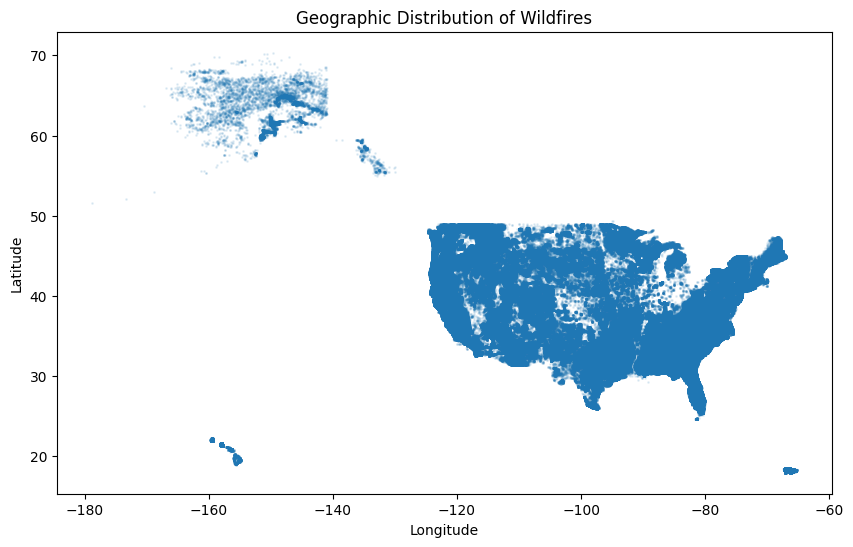

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['LONGITUDE'], df['LATITUDE'], alpha=0.1, s=1)
plt.title('Geographic Distribution of Wildfires')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
